# Association Analysis With Apriori


$$
Support: \frac{A+B}{Total}
$$

Number of transactions in which both items appear

Total number of transactions

$$
Confidence: \frac{A+B}{A}
$$

Number of transactions in which both items appear

Number of transactions in which item A appears

$$
Lift: \frac{Confidence}{\frac{B}{Total} }
$$


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from apyori import apriori       # For Apriori algorithm

# Load And Prepare Data

For this demonstration, we'll use the dataset `Groceries.csv`, which comes from the R package `arules` and is saved as a CSV file. The data is in transactional format (as opposed to tabular format), which means that each row is a list of items purchased together and that the items may be in different order. There are 32 columns in each row, each column either contains a purchased items or `NaN`.

The code below opens the dataset and converts to to list format, which is necessary for the `apriori()` function.

In [4]:
transactions = []

with open('../../assets/Groceries.csv') as f:
    for line in f:
        transaction = [item for item in line.strip().split(',') if item != 'NaN']
        transactions.append(transaction)
    
transactions[:3]

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk']]

# APPLY APRIORI

Call `apriori()` on `transactions`. As parameters `apriori()` can take the minimum support, minimum confidence, minimum lift and minimum items in a transaction. Only the pairs of items that satisfy these criteria would be returned.

In [41]:
rules = list(apriori(
    transactions, 
    min_support=0.001, 
    min_confidence=0.10,
    min_length=2,
    max_length=2))

# Prints one rule
print(rules[0])

RelationRecord(items=frozenset({'bottled water'}), support=0.11052364006100661, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'bottled water'}), confidence=0.11052364006100661, lift=1.0)])


## Convert Rules to Readable Format
The printed rule above is not very clear. Let's convert it to a more readable format. We'll add a `From` and `To` field to the DataFrame, to indicate a rule's antecedent and consequent respectively. Hence for a rule of the form `A->B`. The `From` will contain `A` and `To` will contain `B`. We'll also add the `Support`, `Confidence` and `Lift` corresponding to each rule in the DataFrame. 

In [6]:
rules_df = pd.DataFrame(
    [{'From': list(rule[0])[0],
    'To': list(rule[0])[1],
    'Support': rule[1],
    'Confidence': rule[2][0][2],
    'Lift': rule[2][0][3]} for rule in rules if len(rule[0]) == 2])
rules_df = rules_df.dropna()

rules_df.head()

,From,To,Support,Confidence,Lift
0,Instant food products,bottled water,0.001017,0.126582,1.145296
1,butter,Instant food products,0.001220,0.151899,2.741145
2,Instant food products,citrus fruit,0.001118,0.139241,1.682347
3,Instant food products,curd,0.001322,0.164557,3.088583
4,domestic eggs,Instant food products,0.001017,0.126582,1.995091


## List Rules with N's
The code below calls `plot()` on each row of the rules DataFrame to create a list of all the mined rules. First, we have to add two numeric columns corresponding to each item to `rules_df`.

In [7]:
# Pick top rules
rules_df = rules_df.sort_values('Support', ascending=False).head(50)

# List of all items
items = set(rules_df['From']) | set(rules_df['To'])

# Creates a mapping of items to numbers
imap = {item : i for i, item in enumerate(items)}

# Maps the items to numbers and adds the numeric 'FromN' and 'ToN' columns
rules_df['FromN'] = rules_df['From'].map(imap)
rules_df['ToN'] = rules_df['To'].map(imap)

# Displays the top 20 association rules, sorted by Support
rules_df.head(20)

,From,To,Support,Confidence,Lift,FromN,ToN
1539,other vegetables,whole milk,0.074835,0.386758,1.513634,0,1
1744,rolls/buns,whole milk,0.056634,0.307905,1.205032,8,1
1929,whole milk,yogurt,0.056024,0.219260,1.571735,1,2
1769,whole milk,root vegetables,0.048907,0.448694,1.756031,1,20
1506,other vegetables,root vegetables,0.047382,0.244877,2.246605,0,20
1540,other vegetables,yogurt,0.043416,0.224383,1.608457,0,2
1505,other vegetables,rolls/buns,0.042603,0.220179,1.197047,0,8
1911,tropical fruit,whole milk,0.042298,0.403101,1.577595,7,1
1864,whole milk,soda,0.040061,0.229738,0.899112,1,18
1725,rolls/buns,soda,0.038332,0.208402,1.195124,8,18


## Plot Rules
Plot each pair of items in the rule. If a rule is A->B, then the item A is in the bottom row of the plot (y=0) and B is in the top row (y=1). The color of each line indicates the support of the rule multiplied by 100 (support*100). The width of each line is controlled by the confidence of each rule.

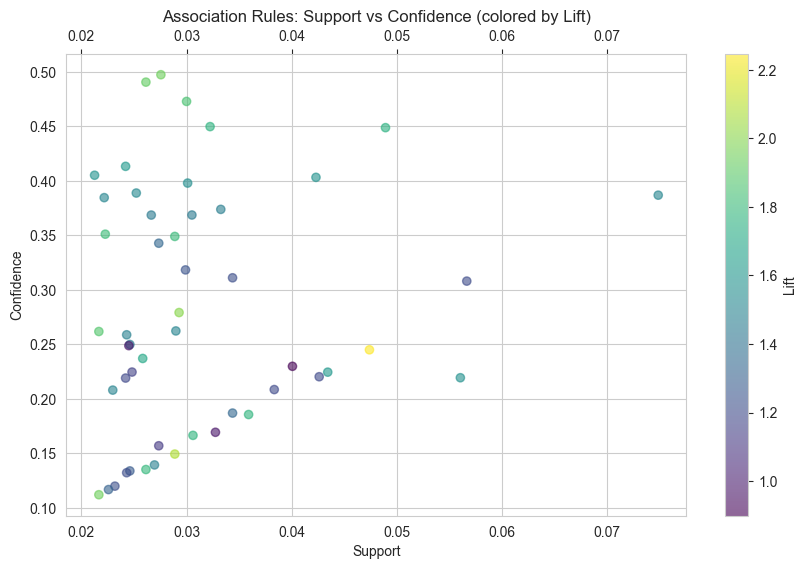

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(rules_df['Support'], rules_df['Confidence'],
           c=rules_df['Lift'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.show()

In [30]:
rules_df

,From,To,Support,Confidence,Lift,FromN,ToN
1539,other vegetables,whole milk,0.074835,0.386758,1.513634,0,1
1744,rolls/buns,whole milk,0.056634,0.307905,1.205032,8,1
1929,whole milk,yogurt,0.056024,0.219260,1.571735,1,2
1769,whole milk,root vegetables,0.048907,0.448694,1.756031,1,20
1506,other vegetables,root vegetables,0.047382,0.244877,2.246605,0,20
1540,other vegetables,yogurt,0.043416,0.224383,1.608457,0,2
1505,other vegetables,rolls/buns,0.042603,0.220179,1.197047,0,8
1911,tropical fruit,whole milk,0.042298,0.403101,1.577595,7,1
1864,whole milk,soda,0.040061,0.229738,0.899112,1,18
1725,rolls/buns,soda,0.038332,0.208402,1.195124,8,18


In [38]:


fig = px.scatter(rules_df, x='Support', y='Confidence',
                size='Lift', color='Lift',
                hover_data=['From', 'To'],
                title='Interactive Association Rules Plot')
fig.show()